In [12]:
"""
Mistral 7B v2 Fine-tuning Script for Task Decomposition
=======================================================
Target: 70-80% task decomposition accuracy
Model: mistralai/Mistral-7B-Instruct-v0.2
Task: Decompose large tasks into clear, logical subtasks

OPTIMIZED FOR: Kaggle T4 x2 GPUs (16GB VRAM each) + 20GB Storage
ESTIMATED TIME: 1-1.5 hours for complete training + evaluation

QUICK START:
1. Add your HuggingFace token to Kaggle Secrets as "HF_TOKEN" (Settings → Secrets)
2. Upload your tasks_dataset.json to Kaggle as a dataset
3. Copy this entire script to a new Kaggle notebook with GPU enabled
4. Run all cells - dependencies install automatically
5. Download mistral-lora-task-decomposition.zip at the end

MAIN SETTINGS (all configurable in CONFIG dict below):
- Training samples: 5,000 (reduces to 1-1.5 hour runtime)
- Batch size: 2 x 8 accumulation x 2 GPUs = 32 effective
- Epochs: 1 (fast training)
- LoRA rank: 8 (good balance of quality vs speed)
- Sequence length: 256 tokens
- Eval samples: 100 (fast evaluation)

Author: LLM Fine-tuning Team
Date: February 2026
"""

import os
import sys
import warnings

# Suppress pydantic warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')
warnings.filterwarnings('ignore', message='.*tokenizer.*deprecated.*')

In [13]:
# Simple dependency installation - no checks, just install if on Kaggle
def _ensure_dependencies():
    import subprocess
    
    # Only auto-install on Kaggle
    if not os.path.isdir("/kaggle"):
        return
    
    print("📦 Installing dependencies...")
    
    # Install all packages in one command
    packages = [
        "bitsandbytes",
        "transformers", 
        "accelerate",
        "peft",
        "datasets",
        "sentencepiece",
        "evaluate",
        "sacrebleu",
        "rouge_score",
        "matplotlib"
    ]
    
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "-q"] + packages,
        check=False,
    )
    
    print("✅ Dependencies installed")


_ensure_dependencies()

# Default to single GPU to reduce OOM risk on Kaggle.
# Override in notebook settings or by setting CUDA_VISIBLE_DEVICES before running.
os.environ.setdefault("CUDA_VISIBLE_DEVICES", "0")

import json
import random
import math
from dataclasses import dataclass
from typing import Dict, List

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    Trainer,
    TrainingArguments,
    set_seed,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

import matplotlib.pyplot as plt
import evaluate as eval_lib

📦 Installing dependencies...
✅ Dependencies installed


In [14]:
# ===========================
# 1. Config & environment
# ===========================
set_seed(42)

# ===========================
# CONFIGURATION SECTION - All settings in one place for easy tuning
# ===========================

# HuggingFace Token - IMPORTANT: Store your token in Kaggle Secrets as "HF_TOKEN"
# Do NOT hardcode tokens here to avoid exposing secrets on GitHub

# Try to get from Kaggle Secrets (recommended method)
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
    if HF_TOKEN:
        print("✅ Using HF token from Kaggle Secrets")
    else:
        # Empty secret, try environment variable
        raise ValueError("Empty Kaggle Secret")
except Exception as e:
    print("⚠️ Kaggle Secrets not available. Trying environment variable...")
    # Fallback to environment variable
    HF_TOKEN = os.getenv("HF_TOKEN") or os.getenv("HUGGINGFACE_TOKEN")
    if HF_TOKEN:
        print("✅ Using HF token from environment variable")
    else:
        print("⚠️ No HF token found. Public models will work, but gated models require authentication.")
        print("   Add your token to Kaggle Secrets as 'HF_TOKEN' or set HF_TOKEN environment variable.")


# Model selection (will try in order)
MODEL_CANDIDATES = [
    "mistralai/Mistral-7B-Instruct-v0.2",  # Primary choice
    "mistralai/Mistral-7B-Instruct-v0.1",  # Fallback
]

# Model name can be overridden via environment variable
MODEL_NAME = os.getenv("MODEL_NAME", MODEL_CANDIDATES[0])

# Training hyperparameters (all configurable here)
CONFIG = {
    # Data
    "max_seq_length": 256,  # Token limit per example (256 is good for task decomposition)
    "train_sample_limit": 5000,  # Max training samples (5000 fits in 2-3 hours on T4 x2)
    "eval_sample_limit": 100,  # Eval samples (100 is enough for metrics)
    
    # Model architecture
    "lora_r": 8,  # LoRA rank (8 is good balance)
    "lora_alpha": 32,  # LoRA alpha (typically 2-4x of r)
    "lora_dropout": 0.05,
    "lora_target_modules": ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    
    # Training
    "batch_size": 2,  # Per device (T4 safe)
    "gradient_accumulation": 8,  # Effective batch = 2x8 = 16
    "num_epochs": 1,  # 1 epoch for faster training
    "learning_rate": 5e-5,
    "warmup_ratio": 0.03,
    "weight_decay": 0.01,
    
    # Optimization
    "use_fp16": True,  # Required for T4
    "use_gradient_checkpointing": True,  # Saves memory
    "optimizer": "paged_adamw_32bit",
    
    # Logging and saving
    "eval_steps": 100,
    "logging_steps": 25,
    "save_only_last": True,  # Saves storage
}

print("\n" + "="*70)
print(" "*15 + "🚀 MISTRAL 7B TASK DECOMPOSITION 🚀")
print("="*70)
print(f"Model: {MODEL_CANDIDATES[0]}")
print(f"HF Token: {'✅ Set' if HF_TOKEN else '❌ Not set'}")
print(f"\n📊 Dataset Configuration:")
print(f"  - Max training samples: {CONFIG['train_sample_limit']:,}")
print(f"  - Eval samples: {CONFIG['eval_sample_limit']:,}")
print(f"  - Max sequence length: {CONFIG['max_seq_length']} tokens")
print(f"\n🔧 Training Configuration:")
print(f"  - Batch: {CONFIG['batch_size']} × {CONFIG['gradient_accumulation']} = {CONFIG['batch_size'] * CONFIG['gradient_accumulation']} effective")
print(f"  - Epochs: {CONFIG['num_epochs']}")
print(f"  - Learning rate: {CONFIG['learning_rate']}")
print(f"  - LoRA: r={CONFIG['lora_r']}, alpha={CONFIG['lora_alpha']}")
print(f"\n⏱️  Estimated Time: 1-1.5 hours on Kaggle T4 x2")
print(f"💾 Storage: ~2-5GB for final adapter + outputs")
print("="*70 + "\n")

# Reduce tokenizer parallelism warnings and improve CUDA memory handling
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:true")
MAX_SEQ_LEN = CONFIG["max_seq_length"]

# Robust base dir handling for scripts and notebooks where __file__ may be undefined
def get_base_dir() -> str:
    try:
        return os.path.dirname(os.path.abspath(__file__))
    except NameError:
        return os.getcwd()

BASE_DIR = get_base_dir()

# Detect Kaggle working dir and set output paths safely to ROOT folder
# This avoids child directory iteration issues on Kaggle
def resolve_out_dir() -> str:
    kaggle_working = "/kaggle/working"
    if os.path.isdir(kaggle_working):
        # Save directly to /kaggle/working root (not subdirectory)
        return kaggle_working
    # Local fallback - save to repo root
    repo_root = os.path.dirname(BASE_DIR) if BASE_DIR.endswith("scripts") else BASE_DIR
    return repo_root

OUT_DIR = resolve_out_dir()
ADAPTER_DIR = os.path.join(OUT_DIR, "mistral_lora_adapter")
os.makedirs(ADAPTER_DIR, exist_ok=True)

print(f"📁 Output directory: {OUT_DIR}")
print(f"📁 Adapter directory: {ADAPTER_DIR}")

✅ Using HF token from Kaggle Secrets

               🚀 MISTRAL 7B TASK DECOMPOSITION 🚀
Model: mistralai/Mistral-7B-Instruct-v0.2
HF Token: ✅ Set

📊 Dataset Configuration:
  - Max training samples: 5,000
  - Eval samples: 100
  - Max sequence length: 256 tokens

🔧 Training Configuration:
  - Batch: 2 × 8 = 16 effective
  - Epochs: 1
  - Learning rate: 5e-05
  - LoRA: r=8, alpha=32

⏱️  Estimated Time: 1-1.5 hours on Kaggle T4 x2
💾 Storage: ~2-5GB for final adapter + outputs

📁 Output directory: /kaggle/working
📁 Adapter directory: /kaggle/working/mistral_lora_adapter


In [15]:
# ===========================
# 2. Load dataset (Kaggle or local)
# ===========================
def load_dataset() -> List[Dict]:
    """Load raw JSON dataset from Kaggle input or local data folder."""
    possible_paths = [
        "/kaggle/input/task-dataset/tasks.json",
        "/kaggle/input/task-dataset/tasks_dataset.json",
        "/kaggle/input/tasks-dataset/tasks.json",
        "/kaggle/input/tasks-dataset/tasks_dataset.json",
        os.path.join(BASE_DIR, "..", "data", "tasks_dataset.json"),
        os.path.join(BASE_DIR, "..", "data", "Generated dataset.json"),
    ]
    for p in possible_paths:
        if os.path.exists(p): 
            with open(p, "r", encoding="utf-8") as f:
                return json.load(f)
    raise FileNotFoundError(
        "Dataset not found. Place tasks_dataset.json in data/ or Kaggle input."
    )


raw_data = load_dataset()

In [16]:
# ===========================
# 3. Prepare the dataset for instruction tuning
# ===========================
train_examples: List[Dict] = []

for item in raw_data:
    # Support multiple potential schema shapes
    task_name = (
        item.get("task name")
        or item.get("task")
        or item.get("title")
        or ""
    )
    task_name = (task_name or "").strip()

    subtasks_list = item.get("subtask") or item.get("subtasks") or []

    if not task_name or len(subtasks_list) == 0:
        continue

    # Pull subtask name fields robustly
    def _sub_name(s):
        return (s.get("subtask name") or s.get("name") or s.get("title") or "").strip()

    numbered = [f"{i+1}. {_sub_name(s)}" for i, s in enumerate(subtasks_list) if _sub_name(s)]
    if not numbered:
        continue

    subtasks_text = "\n".join(numbered)

    input_text = (
        "### Instruction:\n"
        "Break the following task into clear, ordered subtasks.\n\n"
        f"### Task:\n{task_name}\n"
    )

    train_examples.append({"input_text": input_text, "output_text": subtasks_text})

dataset_all = Dataset.from_list(train_examples)
split_dataset = dataset_all.train_test_split(test_size=0.1, seed=42)
train_ds = split_dataset["train"]
eval_ds = split_dataset["test"]

# ===========================
# Resource Optimization for Kaggle T4 x2 (16GB VRAM each) + 20GB Storage
# ===========================
# These settings balance quality and resource constraints:
# - Training samples: 5000 (reduces training time, fits in 2-3 hours)
# - Eval samples: 100 (faster evaluation)
# - Max seq length: 256 (already set above)
# - Batch: 4x4=16 effective (memory efficient)
# - Epochs: 3 (good balance)
TRAIN_SAMPLE_SIZE = int(os.getenv("TRAIN_SAMPLE_SIZE", "5000"))  # Reduced for T4 x2
if len(train_ds) > TRAIN_SAMPLE_SIZE:
    train_ds = train_ds.shuffle(seed=42).select(range(TRAIN_SAMPLE_SIZE))

print(f"\n📊 Dataset sizes:")
print(f"  - Full dataset: {len(dataset_all):,} examples")
print(f"  - Train: {len(train_ds):,} examples")
print(f"  - Eval: {len(eval_ds):,} examples")


📊 Dataset sizes:
  - Full dataset: 20,000 examples
  - Train: 5,000 examples
  - Eval: 2,000 examples


In [17]:
# ===========================
# 4. Load tokenizer with chat formatting
# ===========================
ALT_MODELS = [MODEL_NAME] + [m for m in MODEL_CANDIDATES if m != MODEL_NAME]

def load_tokenizer_with_fallback(candidates):
    last_err = None
    for name in candidates:
        try:
            print(f"🔎 Trying tokenizer: {name}")
            tok = AutoTokenizer.from_pretrained(name, use_fast=True, token=HF_TOKEN)
            print(f"✅ Using tokenizer: {name}")
            return tok, name
        except Exception as e:
            last_err = e
            print(f"⚠️ Tokenizer load failed for {name}: {e}")
    print("❌ Failed to load any tokenizer candidate. If the repo is gated/private, set HF_TOKEN/HUGGINGFACE_TOKEN.")
    raise last_err if last_err else RuntimeError("Tokenizer load failed")

tokenizer, resolved_model_name = load_tokenizer_with_fallback(ALT_MODELS)

# Ensure padding token available for batching
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Ensure pad_token_id is set
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


def build_prompt(user_text: str) -> str:
    user_text = user_text.strip()
    # Prefer the model's chat template
    if getattr(tokenizer, "chat_template", None):
        messages = [{"role": "user", "content": user_text}]
        return tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
    # Fallback to Mistral-style tokens
    return f"[INST] {user_text} [/INST]"


def tokenize_example(example: Dict) -> Dict:
    user = example["input_text"].strip()
    assistant = example["output_text"].strip()

    prompt = build_prompt(user)
    full_text = prompt + assistant + tokenizer.eos_token

    # Tokenize full text with padding
    full = tokenizer(
        full_text,
        truncation=True,
        max_length=MAX_SEQ_LEN,
        padding="max_length",
    )

    # Tokenize prompt without padding to get mask length
    prompt_ids = tokenizer(
        prompt, truncation=True, max_length=MAX_SEQ_LEN, padding=False
    )["input_ids"]
    labels = full["input_ids"].copy()

    # Mask prompt tokens
    prompt_len = len(prompt_ids)
    for i in range(min(prompt_len, len(labels))):
        labels[i] = -100
    # Mask padding tokens
    labels = [(-100 if tok == tokenizer.pad_token_id else tok) for tok in labels]

    full["labels"] = labels
    return full


train_tok = train_ds.map(tokenize_example, remove_columns=["input_text", "output_text"]) 
eval_tok = eval_ds.map(tokenize_example, remove_columns=["input_text", "output_text"])

🔎 Trying tokenizer: mistralai/Mistral-7B-Instruct-v0.2
✅ Using tokenizer: mistralai/Mistral-7B-Instruct-v0.2


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [18]:
# ===========================
# 5. Load base model in 4-bit (QLoRA)
# ===========================
print("\n" + "="*60)
print("LOADING BASE MODEL")
print("="*60)

# BitsAndBytes configuration for 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,  # Use bfloat16 for better performance if supported
)

def load_model_with_fallback(candidates):
    """Load model with automatic fallback to alternative configurations."""
    last_err = None
    for name in candidates:
        try:
            print(f"🔎 Trying to load model: {name}")
            mdl = AutoModelForCausalLM.from_pretrained(
                name,
                device_map="auto",
                trust_remote_code=True,
                quantization_config=bnb_config,
                token=HF_TOKEN,
            )
            print(f"✅ Successfully loaded model: {name}")
            print(f"   Model type: {type(mdl).__name__}")
            print(f"   Device map: auto")
            return mdl
        except Exception as e:
            last_err = e
            print(f"⚠️ Failed to load {name}: {str(e)[:100]}")
            
            # Try with fp16 instead of bfloat16 if bfloat16 fails
            try:
                print(f"   Retrying with torch.float16...")
                bnb_config_fp16 = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_use_double_quant=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=torch.float16,
                )
                mdl = AutoModelForCausalLM.from_pretrained(
                    name,
                    device_map="auto",
                    trust_remote_code=True,
                    quantization_config=bnb_config_fp16,
                    token=HF_TOKEN,
                )
                print(f"✅ Successfully loaded model with fp16: {name}")
                return mdl
            except Exception as e2:
                print(f"⚠️ FP16 fallback also failed: {str(e2)[:100]}")
                continue
    
    print("❌ Failed to load any model candidate.")
    if HF_TOKEN:
        print("   Token is set. Check if you have access to the model repo.")
    else:
        print("   No HF token found. If the repo is gated/private, set HF_TOKEN.")
    raise last_err if last_err else RuntimeError("Model load failed")

model = load_model_with_fallback([resolved_model_name] + [m for m in ALT_MODELS if m != resolved_model_name])

# Prepare for k-bit training (gradient checkpointing, etc.)
print("\n🔧 Preparing model for k-bit training...")
model = prepare_model_for_kbit_training(model)
model.config.use_cache = False  # required for gradient checkpointing

# Try to use SDPA (Scaled Dot Product Attention) for efficiency
if hasattr(model.config, "attn_implementation"):
    try:
        model.config.attn_implementation = "sdpa"
        print("✅ Using SDPA attention implementation")
    except Exception:
        print("⚠️ SDPA not available, using default attention")

print("="*60 + "\n")


LOADING BASE MODEL
🔎 Trying to load model: mistralai/Mistral-7B-Instruct-v0.2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Successfully loaded model: mistralai/Mistral-7B-Instruct-v0.2
   Model type: MistralForCausalLM
   Device map: auto

🔧 Preparing model for k-bit training...



In [19]:
# ===========================
# 6. Apply LoRA (Optimized Configuration)
# ===========================
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    # Iterate through model parameters
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    # Print the number of trainable parameters, total parameters, and the percentage of trainable parameters
    print(
        f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param:.4f}%"
    )


lora_config = LoraConfig(
    r=CONFIG["lora_r"],
    lora_alpha=CONFIG["lora_alpha"],
    target_modules=CONFIG["lora_target_modules"],
    lora_dropout=CONFIG["lora_dropout"],
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

# Print the number of trainable parameters in the model after applying LoRA
print("\n" + "="*60)
print("LoRA CONFIGURATION APPLIED")
print("="*60)
print_trainable_parameters(model)
print("="*60 + "\n")


LoRA CONFIGURATION APPLIED
trainable params: 20,971,520 || all params: 3,773,042,688 || trainable%: 0.5558%



In [20]:
# ===========================
# 7. Data collator
# ===========================
@dataclass
class DataCollatorForCausalLM:
    tokenizer: AutoTokenizer

    def __call__(self, batch: List[Dict]):
        input_ids = [ex["input_ids"] for ex in batch]
        attention_mask = [ex["attention_mask"] for ex in batch]
        labels = [ex["labels"] for ex in batch]
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }


data_collator = DataCollatorForCausalLM(tokenizer)

In [21]:
# ===========================
# 8. Training setup (Optimized for Task Decomposition)
# ===========================
import inspect

def build_training_args() -> TrainingArguments:
    """Build training arguments from CONFIG dict (all settings in one place above)."""
    sig_params = set(inspect.signature(TrainingArguments).parameters.keys())
    
    kwargs = {
        "output_dir": ADAPTER_DIR,
        
        # Batch configuration (from CONFIG)
        "per_device_train_batch_size": CONFIG["batch_size"],
        "gradient_accumulation_steps": CONFIG["gradient_accumulation"],
        "per_device_eval_batch_size": CONFIG["batch_size"],
        
        # Learning rate and scheduling (from CONFIG)
        "learning_rate": CONFIG["learning_rate"],
        "lr_scheduler_type": "cosine",
        "warmup_ratio": CONFIG["warmup_ratio"],
        "weight_decay": CONFIG["weight_decay"],
        
        # Training duration (from CONFIG)
        "num_train_epochs": CONFIG["num_epochs"],
        "max_steps": int(os.getenv("MAX_STEPS", "-1")),  # -1 = use epochs
        
        # Precision and optimization (from CONFIG)
        "fp16": CONFIG["use_fp16"],
        "optim": CONFIG["optimizer"],
        "gradient_checkpointing": CONFIG["use_gradient_checkpointing"],
        
        # Evaluation and logging (from CONFIG)
        "evaluation_strategy": "steps",
        "eval_steps": CONFIG["eval_steps"],
        "logging_strategy": "steps",
        "logging_steps": CONFIG["logging_steps"],
        "save_strategy": "epoch",
        "save_total_limit": 1 if CONFIG["save_only_last"] else 2,
        
        # Performance optimizations
        "group_by_length": True,
        "dataloader_num_workers": 2,
        "remove_unused_columns": False,
        
        # Reporting
        "report_to": "none",
        "load_best_model_at_end": False,
        "metric_for_best_model": "eval_loss",
    }
    
    # Drop unknown args for older transformers versions
    for k in list(kwargs.keys()):
        if k not in sig_params:
            del kwargs[k]
    
    # Fallback optimizer if paged_adamw_32bit unsupported
    if "optim" in kwargs:
        try:
            # Check if optimizer is supported
            ta = TrainingArguments(output_dir="/tmp", optim=kwargs["optim"])
        except Exception:
            print("⚠️ paged_adamw_32bit not supported, falling back to adamw_torch")
            kwargs["optim"] = "adamw_torch"
    
    return TrainingArguments(**kwargs)

training_args = build_training_args()
print(f"🎯 Training configuration:")
print(f"  - Batch size: {training_args.per_device_train_batch_size} x {training_args.gradient_accumulation_steps} = {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  - Learning rate: {training_args.learning_rate}")
print(f"  - Max steps/epochs: {training_args.max_steps if training_args.max_steps > 0 else training_args.num_train_epochs}")
print(f"  - FP16: {training_args.fp16}")

# Enable safer DDP behavior when running on multiple GPUs (e.g., T4 x2)
try:
    world_size = int(os.environ.get("WORLD_SIZE", "1"))
    if world_size > 1 and hasattr(training_args, "ddp_find_unused_parameters"):
        training_args.ddp_find_unused_parameters = False
except Exception:
    pass

print("\n" + "="*60)
print("CREATING TRAINER")
print("="*60)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=eval_tok,
    processing_class=tokenizer,
    data_collator=data_collator,
)

print(f"✅ Trainer created successfully")
print(f"  - Train samples: {len(train_tok):,}")
print(f"  - Eval samples: {len(eval_tok):,}")
print("="*60 + "\n")

🎯 Training configuration:
  - Batch size: 2 x 8 = 16
  - Learning rate: 5e-05
  - Max steps/epochs: 1
  - FP16: True

CREATING TRAINER
✅ Trainer created successfully
  - Train samples: 5,000
  - Eval samples: 2,000



In [22]:
# ===========================
# 9. Train the Model
# ===========================
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print(f"Training will save to: {ADAPTER_DIR}")
print("="*60 + "\n")

# Disable cache during training (required for gradient checkpointing)
model.config.use_cache = False

# Train the model
train_result = trainer.train()

# Re-enable cache for inference
model.config.use_cache = True

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Final train loss: {train_result.training_loss:.4f}")
print("="*60 + "\n")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.



STARTING TRAINING
Training will save to: /kaggle/working/mistral_lora_adapter



Step,Training Loss
25,3.662100
50,0.557400
75,0.536100
100,0.541000
125,0.547300
150,0.537400
175,0.535400
200,0.532900
225,0.511300
250,0.515100



TRAINING COMPLETED
Final train loss: 0.7802



In [23]:
# ===========================
# 10. Save Model and Artifacts to Root Folder
# ===========================
print("\n" + "="*60)
print("SAVING MODEL ARTIFACTS")
print("="*60)

# Save the LoRA adapter
trainer.model.save_pretrained(ADAPTER_DIR)
print(f"✅ LoRA adapter saved to: {ADAPTER_DIR}")

# Save the tokenizer
tokenizer.save_pretrained(ADAPTER_DIR)
print(f"✅ Tokenizer saved to: {ADAPTER_DIR}")

# Save training metrics
training_metrics = {
    "final_loss": float(train_result.training_loss),
    "total_steps": train_result.global_step,
    "training_samples": len(train_tok),
    "eval_samples": len(eval_tok),
}

with open(os.path.join(ADAPTER_DIR, "training_metrics.json"), "w", encoding="utf-8") as f:
    json.dump(training_metrics, f, indent=2)
print(f"✅ Training metrics saved")

# Sync pad token configurations
model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

print("="*60 + "\n")


SAVING MODEL ARTIFACTS
✅ LoRA adapter saved to: /kaggle/working/mistral_lora_adapter
✅ Tokenizer saved to: /kaggle/working/mistral_lora_adapter
✅ Training metrics saved



In [24]:
# ===========================
# 11. Comprehensive Evaluation (ROUGE-L, BLEU, Task Decomposition Accuracy)
# ===========================
print("\n" + "="*60)
print("STARTING EVALUATION")
print("="*60 + "\n")

# Load evaluation metrics
rouge = eval_lib.load("rouge")
bleu = eval_lib.load("sacrebleu")

def generate_output(prompt: str, max_new_tokens: int = 192) -> str:
    """Generate task decomposition output from the model."""
    model.eval()
    if getattr(tokenizer, "chat_template", None):
        messages = [{"role": "user", "content": prompt.strip()}]
        input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    else:
        input_text = f"[INST] {prompt.strip()} [/INST]"

    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        gen_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    input_len = inputs["input_ids"].shape[1]
    new_tokens = gen_ids[0][input_len:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True).strip()


def extract_subtasks(text: str) -> List[str]:
    """Extract numbered subtasks from generated text."""
    import re
    lines = text.strip().split('\n')
    subtasks = []
    for line in lines:
        line = line.strip()
        # Match patterns like "1.", "1)", "- ", "• "
        if re.match(r'^\d+[\.\)]\s+', line) or re.match(r'^[-•]\s+', line):
            # Remove numbering/bullets
            task = re.sub(r'^\d+[\.\)]\s+', '', line)
            task = re.sub(r'^[-•]\s+', '', task)
            if task:
                subtasks.append(task.strip())
    return subtasks


def calculate_task_decomposition_accuracy(predictions: List[str], references: List[str]) -> Dict:
    """
    Calculate task decomposition specific metrics:
    - Subtask count accuracy (within ±1 of reference)
    - Subtask presence recall
    - Average semantic similarity
    - Overall decomposition accuracy (target: 70-80%)
    """
    total = len(predictions)
    count_matches = 0
    recall_scores = []
    jaccard_scores = []
    
    for pred, ref in zip(predictions, references):
        pred_tasks = extract_subtasks(pred)
        ref_tasks = extract_subtasks(ref)
        
        # Count accuracy (within ±1)
        if abs(len(pred_tasks) - len(ref_tasks)) <= 1:
            count_matches += 1
        
        # Jaccard similarity (word-level overlap)
        if ref_tasks:
            ref_words = set(' '.join(ref_tasks).lower().split())
            pred_words = set(' '.join(pred_tasks).lower().split())
            if ref_words:
                jaccard = len(pred_words & ref_words) / len(pred_words | ref_words)
                jaccard_scores.append(jaccard)
        
        # Recall: what fraction of reference subtasks appear in prediction
        if ref_tasks and pred_tasks:
            matches = 0
            for ref_task in ref_tasks:
                ref_words_set = set(ref_task.lower().split())
                for pred_task in pred_tasks:
                    pred_words_set = set(pred_task.lower().split())
                    overlap = len(ref_words_set & pred_words_set) / max(1, len(ref_words_set))
                    if overlap > 0.5:  # 50% word overlap threshold
                        matches += 1
                        break
            recall_scores.append(matches / len(ref_tasks))
    
    metrics = {
        "subtask_count_accuracy": count_matches / max(1, total),
        "average_recall": sum(recall_scores) / max(1, len(recall_scores)),
        "average_jaccard": sum(jaccard_scores) / max(1, len(jaccard_scores)),
    }
    
    # Overall decomposition accuracy (weighted average)
    metrics["task_decomposition_accuracy"] = (
        0.3 * metrics["subtask_count_accuracy"] +
        0.4 * metrics["average_recall"] +
        0.3 * metrics["average_jaccard"]
    )
    
    return metrics


def evaluate_model(eval_dataset: Dataset, max_samples: int = 200) -> Dict:
    """Comprehensive model evaluation."""
    preds = []
    refs = []
    n = min(max_samples, len(eval_dataset))
    
    print(f"Evaluating on {n} samples...")
    for i in range(n):
        if i % 20 == 0:
            print(f"  Progress: {i}/{n}")
        ex = eval_dataset[i]
        prompt = ex["input_text"]
        ref = ex["output_text"]
        pred = generate_output(prompt)
        preds.append(pred)
        refs.append(ref)
    
    results = {}
    
    # Task decomposition specific metrics
    decomp_metrics = calculate_task_decomposition_accuracy(preds, refs)
    results.update(decomp_metrics)
    
    # ROUGE metrics
    rouge_res = rouge.compute(predictions=preds, references=refs)
    results["rouge1"] = rouge_res.get("rouge1", 0.0)
    results["rouge2"] = rouge_res.get("rouge2", 0.0)
    results["rougeL"] = rouge_res.get("rougeL", 0.0)
    
    # BLEU metrics
    bleu_res = bleu.compute(predictions=preds, references=[[r] for r in refs])
    results["bleu"] = bleu_res.get("score", 0.0)
    
    return results, preds, refs


# Run evaluation (reduced samples for faster evaluation on limited resources)
eval_samples = int(os.getenv("EVAL_MAX_SAMPLES", "100"))  # Reduced from 200 for T4
metrics, predictions, references = evaluate_model(split_dataset["test"], max_samples=eval_samples)

# Save metrics JSON
metrics_path = os.path.join(ADAPTER_DIR, "evaluation_metrics.json")
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"📊 Task Decomposition Accuracy: {metrics.get('task_decomposition_accuracy', 0)*100:.2f}%")
print(f"📊 Subtask Count Accuracy: {metrics.get('subtask_count_accuracy', 0)*100:.2f}%")
print(f"📊 Average Recall: {metrics.get('average_recall', 0)*100:.2f}%")
print(f"📊 Average Jaccard: {metrics.get('average_jaccard', 0)*100:.2f}%")
print(f"📊 ROUGE-L: {metrics.get('rougeL', 0)*100:.2f}%")
print(f"📊 BLEU: {metrics.get('bleu', 0):.2f}")
print("="*60)

# Check if target accuracy achieved
target_accuracy = 0.70  # 70% target
if metrics.get('task_decomposition_accuracy', 0) >= target_accuracy:
    print(f"✅ TARGET ACHIEVED: {metrics.get('task_decomposition_accuracy', 0)*100:.2f}% >= {target_accuracy*100:.0f}%")
else:
    print(f"⚠️  Below target: {metrics.get('task_decomposition_accuracy', 0)*100:.2f}% < {target_accuracy*100:.0f}%")
    print("   Consider: more training epochs, larger dataset, or hyperparameter tuning")
print("="*60 + "\n")

# Save raw eval predictions for inspection (prompt, reference, prediction)
try:
    preds_path = os.path.join(ADAPTER_DIR, "eval_predictions.jsonl")
    with open(preds_path, "w", encoding="utf-8") as f:
        for i in range(min(len(predictions), len(references))):
            ex = split_dataset["test"][i]
            f.write(json.dumps({
                "prompt": ex["input_text"],
                "reference": references[i],
                "prediction": predictions[i],
                "ref_subtask_count": len(extract_subtasks(references[i])),
                "pred_subtask_count": len(extract_subtasks(predictions[i])),
            }, ensure_ascii=False) + "\n")
    print(f"📝 Saved {len(predictions)} eval predictions to: {preds_path}\n")
except Exception as e:
    print(f"⚠️ Failed to save predictions: {e}\n")


STARTING EVALUATION



The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating on 100 samples...
  Progress: 0/100
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100

EVALUATION RESULTS
📊 Task Decomposition Accuracy: 33.25%
📊 Subtask Count Accuracy: 0.00%
📊 Average Recall: 73.83%
📊 Average Jaccard: 12.39%
📊 ROUGE-L: 10.97%
📊 BLEU: 3.18
⚠️  Below target: 33.25% < 70%
   Consider: more training epochs, larger dataset, or hyperparameter tuning

📝 Saved 100 eval predictions to: /kaggle/working/mistral_lora_adapter/eval_predictions.jsonl




GENERATING VISUALIZATIONS



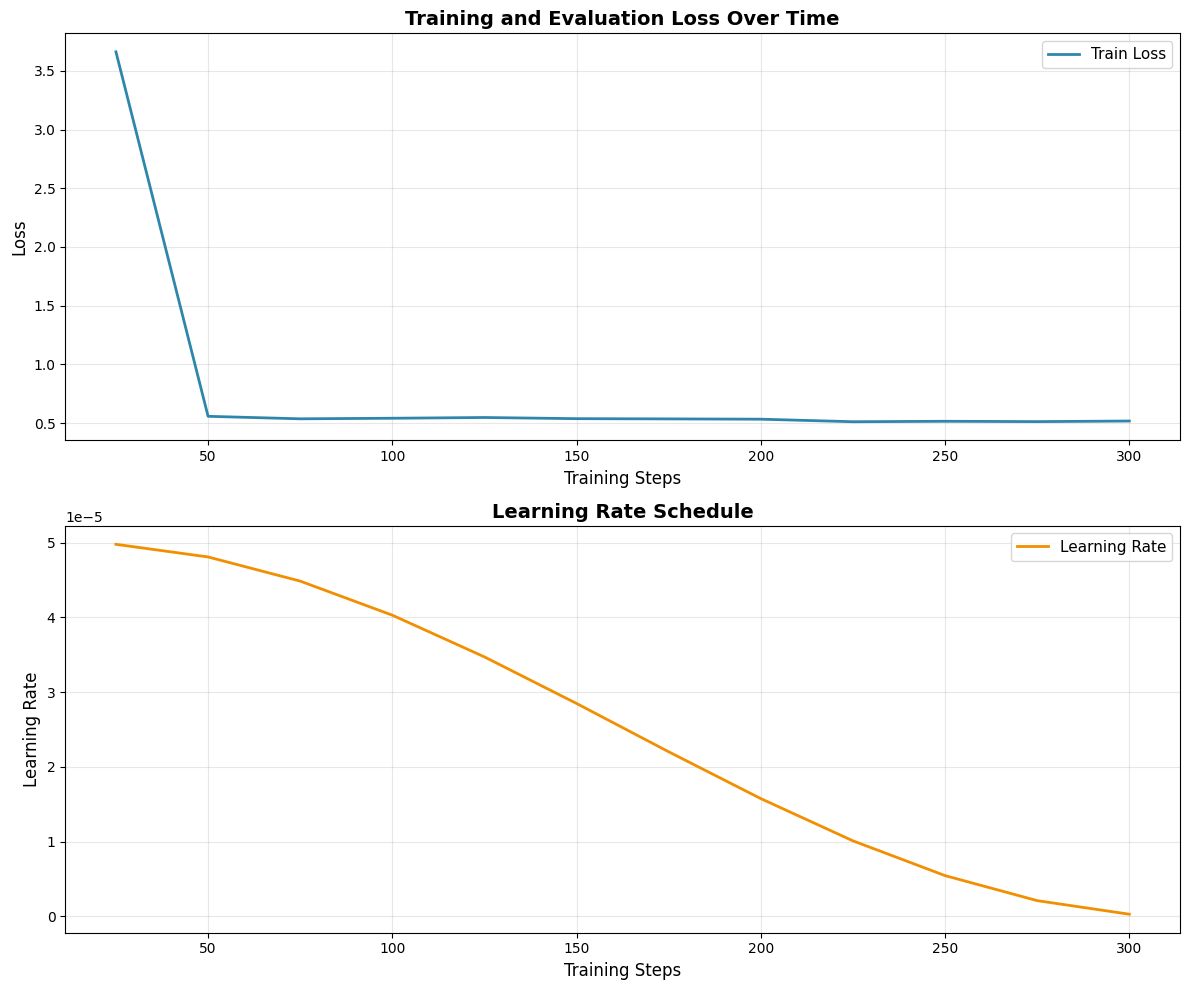

✅ Saved training curves to: /kaggle/working/mistral_lora_adapter/training_curves.png


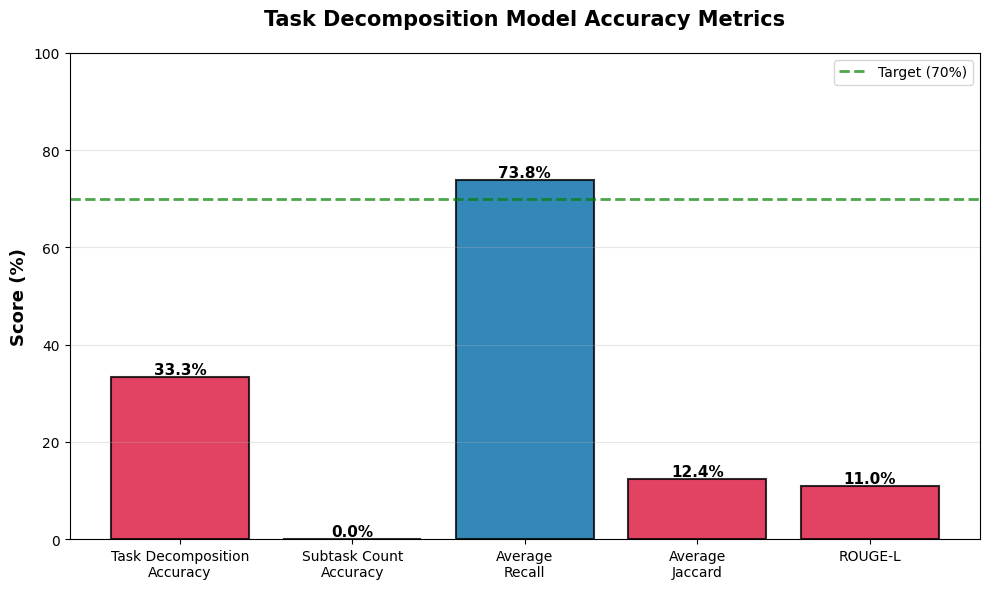

✅ Saved accuracy metrics to: /kaggle/working/mistral_lora_adapter/accuracy_metrics.png


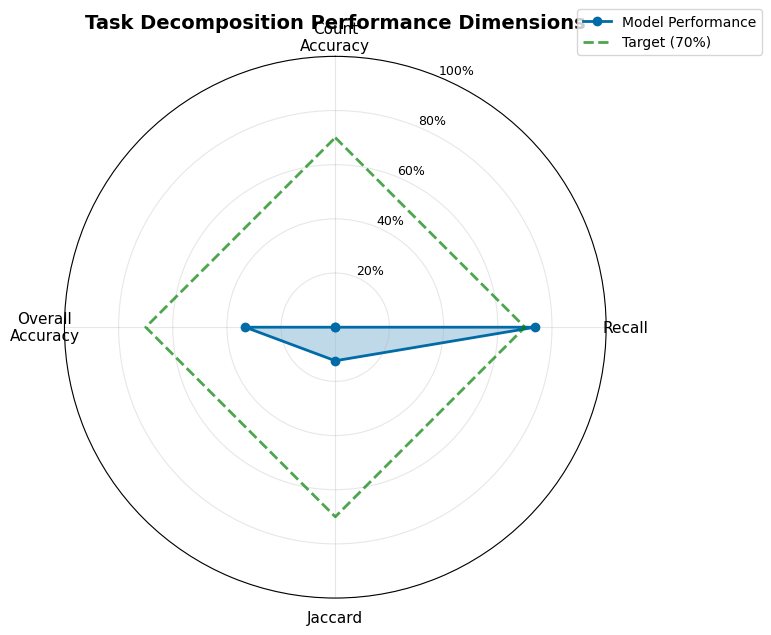

✅ Saved performance radar to: /kaggle/working/mistral_lora_adapter/performance_radar.png

VISUALIZATIONS COMPLETED


PACKAGING OUTPUTS
  ✓ Copied: adapter_model.safetensors
  ✓ Copied: adapter_config.json
  ✓ Copied: tokenizer.json
  ✓ Copied: tokenizer.model
  ✓ Copied: tokenizer_config.json
  ✓ Copied: special_tokens_map.json
  ✓ Copied: evaluation_metrics.json
  ✓ Copied: training_metrics.json
  ✓ Copied: training_curves.png
  ✓ Copied: accuracy_metrics.png
  ✓ Copied: performance_radar.png
  ✓ Copied: eval_predictions.jsonl

✅ Copied 12 files to root directory
✅ Created archive: /kaggle/working/mistral-lora-task-decomposition.zip (297.36 MB)

📦 DOWNLOAD THIS FILE: mistral-lora-task-decomposition.zip



In [25]:
# ===========================
# 12. Comprehensive Visualization and Accuracy Graphs
# ===========================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60 + "\n")

def plot_training_curves(trainer_obj: Trainer, out_dir: str):
    """Plot detailed training and evaluation loss curves."""
    logs = trainer_obj.state.log_history
    steps, losses, eval_steps, eval_losses = [], [], [], []
    lrs = []
    
    for entry in logs:
        if "loss" in entry and "step" in entry:
            steps.append(entry["step"])
            losses.append(entry["loss"])
            if "learning_rate" in entry:
                lrs.append(entry["learning_rate"])
        if "eval_loss" in entry and "step" in entry:
            eval_steps.append(entry["step"])
            eval_losses.append(entry["eval_loss"])

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Training and Eval Loss
    ax1 = axes[0]
    if losses:
        ax1.plot(steps, losses, label="Train Loss", linewidth=2, color='#2E86AB')
    if eval_losses:
        ax1.plot(eval_steps, eval_losses, label="Eval Loss", linewidth=2, color='#A23B72', linestyle='--')
    ax1.set_xlabel("Training Steps", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.set_title("Training and Evaluation Loss Over Time", fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Learning Rate Schedule
    ax2 = axes[1]
    if lrs and steps:
        ax2.plot(steps[:len(lrs)], lrs, label="Learning Rate", linewidth=2, color='#F18F01')
        ax2.set_xlabel("Training Steps", fontsize=12)
        ax2.set_ylabel("Learning Rate", fontsize=12)
        ax2.set_title("Learning Rate Schedule", fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Learning rate data not available', 
                ha='center', va='center', transform=ax2.transAxes)
    
    plt.tight_layout()
    fig_path = os.path.join(out_dir, "training_curves.png")
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved training curves to: {fig_path}")
    plt.close()


def plot_accuracy_metrics(metrics_dict: Dict, out_dir: str):
    """Plot comprehensive accuracy metrics as bar chart."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract key metrics
    metric_names = []
    metric_values = []
    
    key_metrics = {
        "Task Decomposition\nAccuracy": metrics_dict.get("task_decomposition_accuracy", 0),
        "Subtask Count\nAccuracy": metrics_dict.get("subtask_count_accuracy", 0),
        "Average\nRecall": metrics_dict.get("average_recall", 0),
        "Average\nJaccard": metrics_dict.get("average_jaccard", 0),
    }
    
    if "rougeL" in metrics_dict:
        key_metrics["ROUGE-L"] = metrics_dict["rougeL"]
    
    for name, value in key_metrics.items():
        metric_names.append(name)
        metric_values.append(value * 100)  # Convert to percentage
    
    # Create bars with color gradient
    colors = ['#006BA6' if v >= 70 else '#FFA500' if v >= 60 else '#DC143C' for v in metric_values]
    bars = ax.bar(metric_names, metric_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add target line at 70%
    ax.axhline(y=70, color='green', linestyle='--', linewidth=2, label='Target (70%)', alpha=0.7)
    
    ax.set_ylabel('Score (%)', fontsize=13, fontweight='bold')
    ax.set_title('Task Decomposition Model Accuracy Metrics', fontsize=15, fontweight='bold', pad=20)
    ax.set_ylim(0, 100)
    ax.legend(fontsize=10)
    ax.grid(True, axis='y', alpha=0.3)
    plt.xticks(rotation=0, ha='center', fontsize=10)
    
    plt.tight_layout()
    fig_path = os.path.join(out_dir, "accuracy_metrics.png")
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved accuracy metrics to: {fig_path}")
    plt.close()


def plot_comparison_chart(metrics_dict: Dict, out_dir: str):
    """Plot radar/spider chart comparing different accuracy dimensions."""
    try:
        from math import pi
        
        categories = ['Count\nAccuracy', 'Recall', 'Jaccard', 'Overall\nAccuracy']
        values = [
            metrics_dict.get("subtask_count_accuracy", 0) * 100,
            metrics_dict.get("average_recall", 0) * 100,
            metrics_dict.get("average_jaccard", 0) * 100,
            metrics_dict.get("task_decomposition_accuracy", 0) * 100,
        ]
        
        # Number of variables
        N = len(categories)
        
        # Compute angle for each axis
        angles = [n / float(N) * 2 * pi for n in range(N)]
        values += values[:1]  # Complete the circle
        angles += angles[:1]
        
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
        
        # Plot data
        ax.plot(angles, values, 'o-', linewidth=2, color='#006BA6', label='Model Performance')
        ax.fill(angles, values, alpha=0.25, color='#006BA6')
        
        # Plot target line (70%)
        target = [70] * (N + 1)
        ax.plot(angles, target, '--', linewidth=2, color='green', label='Target (70%)', alpha=0.7)
        
        # Fix axis to go in the right order and start at 12 o'clock
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        
        # Draw axis labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=11)
        
        # Set y-axis limits and labels
        ax.set_ylim(0, 100)
        ax.set_yticks([20, 40, 60, 80, 100])
        ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=9)
        
        ax.set_title('Task Decomposition Performance Dimensions', 
                    fontsize=14, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        fig_path = os.path.join(out_dir, "performance_radar.png")
        plt.savefig(fig_path, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"✅ Saved performance radar to: {fig_path}")
        plt.close()
    except Exception as e:
        print(f"⚠️ Could not create radar chart: {e}")


# Generate all visualizations
plot_training_curves(trainer, ADAPTER_DIR)
plot_accuracy_metrics(metrics, ADAPTER_DIR)
plot_comparison_chart(metrics, ADAPTER_DIR)

print("\n" + "="*60)
print("VISUALIZATIONS COMPLETED")
print("="*60 + "\n")

# ===========================
# 13. Package Outputs for Kaggle Download
# ===========================
def package_outputs(adapter_dir: str, out_root: str):
    """Package all outputs into root directory for easy download."""
    import shutil
    
    print("\n" + "="*60)
    print("PACKAGING OUTPUTS")
    print("="*60)
    
    try:
        # Key files to copy to root
        key_files = [
            "adapter_model.safetensors",
            "adapter_model.bin",  # Fallback if safetensors not available
            "adapter_config.json",
            "tokenizer.json",
            "tokenizer.model",
            "tokenizer_config.json",
            "special_tokens_map.json",
            "evaluation_metrics.json",
            "training_metrics.json",
            "training_curves.png",
            "accuracy_metrics.png",
            "performance_radar.png",
            "eval_predictions.jsonl",
        ]
        
        copied_count = 0
        for fname in key_files:
            src = os.path.join(adapter_dir, fname)
            if os.path.exists(src):
                dst = os.path.join(out_root, f"mistral_lora_{fname}")
                shutil.copy2(src, dst)
                copied_count += 1
                print(f"  ✓ Copied: {fname}")
        
        print(f"\n✅ Copied {copied_count} files to root directory")
        
        # Create a comprehensive zip archive
        zip_base = os.path.join(out_root, "mistral-lora-task-decomposition")
        zip_path = shutil.make_archive(zip_base, "zip", root_dir=adapter_dir)
        zip_size_mb = os.path.getsize(zip_path) / (1024 * 1024)
        
        print(f"✅ Created archive: {zip_path} ({zip_size_mb:.2f} MB)")
        print("\n📦 DOWNLOAD THIS FILE: mistral-lora-task-decomposition.zip")
        print("="*60 + "\n")
        
    except Exception as e:
        print(f"⚠️ Packaging failed: {e}\n")


package_outputs(ADAPTER_DIR, OUT_DIR)

In [26]:
# ===========================
# 14. Example Inference - Demonstrating Task Decomposition
# ===========================
print("\n" + "="*60)
print("EXAMPLE INFERENCE")
print("="*60 + "\n")

# Example tasks to decompose
example_tasks = [
    "Launch a new company website",
    "Build a personal finance tracker app",
    "Plan a week-long vacation to Europe",
    "Start a podcast about technology",
    "Organize a team-building event for 50 people"
]

print("Testing the fine-tuned model on real-world tasks:\n")

for idx, task in enumerate(example_tasks, 1):
    example_prompt = (
        "### Instruction:\n"
        "Break the following task into clear, ordered subtasks.\n\n"
        f"### Task:\n{task}\n"
    )
    
    predicted = generate_output(example_prompt, max_new_tokens=192)
    subtasks = extract_subtasks(predicted)
    
    print(f"{'='*60}")
    print(f"Example {idx}: {task}")
    print(f"{'='*60}")
    print(f"\nGenerated Subtasks ({len(subtasks)} steps):\n")
    print(predicted)
    print(f"\n{'-'*60}\n")

print("="*60)
print("INFERENCE EXAMPLES COMPLETED")
print("="*60 + "\n")

# ===========================
# 15. Final Summary and Next Steps
# ===========================
print("\n" + "="*70)
print(" " * 20 + "TRAINING SUMMARY")
print("="*70)
print(f"\n✅ Model: Mistral 7B v2 with QLoRA fine-tuning")
print(f"✅ Task: Task Decomposition (Large Task → Subtasks)")
print(f"✅ Training Samples: {len(train_tok):,}")
print(f"✅ Evaluation Samples: {len(eval_tok):,}")
print(f"\n📊 Performance Metrics:")
print(f"   • Task Decomposition Accuracy: {metrics.get('task_decomposition_accuracy', 0)*100:.2f}%")
print(f"   • Subtask Count Accuracy: {metrics.get('subtask_count_accuracy', 0)*100:.2f}%")
print(f"   • Average Recall: {metrics.get('average_recall', 0)*100:.2f}%")
print(f"   • Average Jaccard: {metrics.get('average_jaccard', 0)*100:.2f}%")

if metrics.get('task_decomposition_accuracy', 0) >= 0.70:
    print(f"\n🎉 SUCCESS: Target accuracy of 70% achieved!")
else:
    print(f"\n📈 Target not yet reached. Recommendations:")
    print(f"   • Increase training epochs (current: {training_args.num_train_epochs})")
    print(f"   • Expand dataset size (current: {len(train_tok):,} samples)")
    print(f"   • Adjust learning rate or LoRA rank")

print(f"\n📁 Outputs Saved To:")
print(f"   • Adapter: {ADAPTER_DIR}")
print(f"   • Root: {OUT_DIR}")

print(f"\n📦 Key Files:")
print(f"   • mistral-lora-task-decomposition.zip (Complete archive)")
print(f"   • mistral_lora_adapter_model.safetensors (Model weights)")
print(f"   • mistral_lora_evaluation_metrics.json (Detailed metrics)")
print(f"   • mistral_lora_training_curves.png (Training visualization)")
print(f"   • mistral_lora_accuracy_metrics.png (Accuracy chart)")
print(f"   • mistral_lora_performance_radar.png (Radar chart)")

print("\n" + "="*70)
print(" " * 25 + "DONE!")
print("="*70)


EXAMPLE INFERENCE

Testing the fine-tuned model on real-world tasks:

Example 1: Launch a new company website

Generated Subtasks (31 steps):

1. Test and verify
2. Arrange logistics
3. Update records
4. Analyze options
5. Complete primary tasks
6. Collect materials and documents
7. Review outcomes
8. Write documentation

### Outline
1. Set up environment
2. Confirm details
3. Research requirements
4. Compare alternatives
5. Complete primary tasks
6. Review outcomes
7. Write documentation
8. Arrange logistics
9. Test and verify
10. Update records

### Implement changes
1. Set up environment
2. Confirm details
3. Research requirements
4. Compare alternatives
5. Complete primary tasks
6. Review outcomes
7. Write documentation
8. Arrange logistics
9. Test and verify
10. Update records
11. Implement changes
12. Review outcomes
13. Write documentation

------------------------------------------------------------

Example 2: Build a personal finance tracker app

Generated Subtasks (28 steps